# Visualizing temperatures over the years and forecasting with fbProphet

In [38]:

from fbprophet import Prophet
import yfinance as yf
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import pandas as pd 
from fbprophet.plot import plot_plotly
import numpy as np 
import seaborn as sns 

In [3]:
df=pd.read_csv("city_temperature.csv")
df.head()

C:\Users\Ayoub\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [4]:
df.dtypes

Region             object
Country            object
State              object
City               object
Month               int64
Day                 int64
Year                int64
AvgTemperature    float64
dtype: object

In [5]:
df.describe()

,Month,Day,Year,AvgTemperature
count,2.906327e+06,2.906327e+06,2.906327e+06,2.906327e+06
mean,6.469163e+00,1.571682e+01,2.006624e+03,5.600492e+01
std,3.456489e+00,8.800534e+00,2.338226e+01,3.212359e+01
min,1.000000e+00,0.000000e+00,2.000000e+02,-9.900000e+01
25%,3.000000e+00,8.000000e+00,2.001000e+03,4.580000e+01
50%,6.000000e+00,1.600000e+01,2.007000e+03,6.250000e+01
75%,9.000000e+00,2.300000e+01,2.013000e+03,7.550000e+01
max,1.200000e+01,3.100000e+01,2.020000e+03,1.100000e+02


In [76]:
# on drop les années 200 et 201 et la colmun state et city
df.drop(df.index[df["Year"]==201].tolist(),axis=0,inplace=True,errors="ignore") 
df.drop(df.index[df["Year"]==200].tolist(),axis=0,inplace=True,errors="ignore")
df.drop(["State","City"],axis=1,inplace=True,errors="ignore")
df.drop(df.index[df["AvgTemperature"]==-99],axis=0,inplace=True,errors="ignore")
df["date"]=pd.to_datetime((df["Year"]*10000+df["Month"]*100+df["Day"]).apply(str),format='%Y%m%d')
df.head()

,Region,Country,Month,Day,Year,AvgTemperature,date
0,Africa,Algeria,1,1,1995,64.2,1995-01-01
1,Africa,Algeria,1,2,1995,49.4,1995-01-02
2,Africa,Algeria,1,3,1995,48.8,1995-01-03
3,Africa,Algeria,1,4,1995,46.4,1995-01-04
4,Africa,Algeria,1,5,1995,47.9,1995-01-05


In [6]:
print(df["Year"].value_counts())

2000    119682
1999    119355
2001    119355
2002    119355
2003    119140
1998    119082
1996    118951
1997    118656
2004    118645
1995    118616
2005    117895
2006    117647
2010    115627
2007    115428
2008    114908
2009    114247
2011    113740
2012    111993
2013    111021
2014    109018
2015    107498
2016    107237
2017    106946
2018    106698
2019    106337
2020     38810
Name: Year, dtype: int64


In [176]:
temps=df.groupby(["Country","date"])["AvgTemperature"].mean()
temps.head(10)


Country  date      
Albania  1997-04-21    55.4
         1997-04-25    56.8
         1997-04-26    61.5
         1997-04-27    60.8
         1997-04-28    57.2
         1997-05-01    66.2
         1997-05-02    67.2
         1997-05-03    68.9
         1997-05-04    70.5
         1997-05-09    60.3
Name: AvgTemperature, dtype: float64

In [80]:
temps_C=(temps-32.0)/1.8 # conversion F vers C
temps_C.head()

Country  date      
Albania  1997-04-21    13.000000
         1997-04-25    13.777778
         1997-04-26    16.388889
         1997-04-27    16.000000
         1997-04-28    14.000000
Name: AvgTemperature, dtype: float64

In [82]:
France=temps_C.iloc[temps_C.index.get_level_values('Country') == "France"].droplevel("Country") # On garde que les T pour la France

<AxesSubplot:xlabel='date', ylabel='AvgTemperature'>

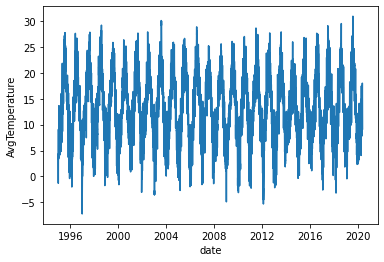

In [84]:
sns.lineplot(data=France)

In [61]:
df["Country"].unique()

array(['Algeria', 'Burundi', 'Benin', 'Central African Republic', 'Congo',
       'Egypt', 'Ethiopia', 'Gabon', 'Gambia', 'Guinea', 'Guinea-Bissau',
       'Ivory Coast', 'Kenya', 'Morocco', 'Madagascar', 'Mauritania',
       'Malawi', 'Mozambique', 'Namibia', 'Nigeria', 'Senegal',
       'Sierra Leone', 'South Africa', 'Togo', 'Tunisia', 'Tanzania',
       'Uganda', 'Zambia', 'Bangladesh', 'China', 'Hong Kong', 'India',
       'Indonesia', 'Japan', 'Kazakhstan', 'Kyrgyzstan', 'Laos',
       'Malaysia', 'Mongolia', 'Myanmar (Burma)', 'Nepal', 'North Korea',
       'Pakistan', 'Philippines', 'Singapore', 'South Korea', 'Sri Lanka',
       'Taiwan', 'Tajikistan', 'Thailand', 'Turkmenistan', 'Uzbekistan',
       'Vietnam', 'Australia', 'New Zealand', 'Albania', 'Austria',
       'Belarus', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany',
       'Georgia', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Latvia', 'Ma

In [85]:
# grouping every temperature by country 
countries={}
for country in df["Country"].unique() :
    temp=temps_C.iloc[temps_C.index.get_level_values('Country') == country].droplevel("Country")
    temp=pd.DataFrame({"ds":temp.index,"y":temp}).reset_index(drop=True)
    countries[country]=temp
    

In [91]:
df.dtypes

Region                    object
Country                   object
Month                      int64
Day                        int64
Year                       int64
AvgTemperature           float64
date              datetime64[ns]
dtype: object

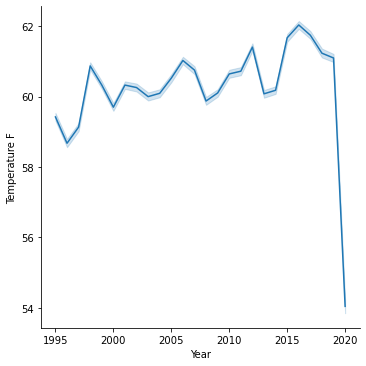

In [128]:
# On plot les temperatures
ax=sns.relplot(x=df["Year"],y=df["AvgTemperature"],kind="line")
ax.set_titles("Temperatures over the year",loc="center",y=1)
ax.set_ylabels("Temperature F")



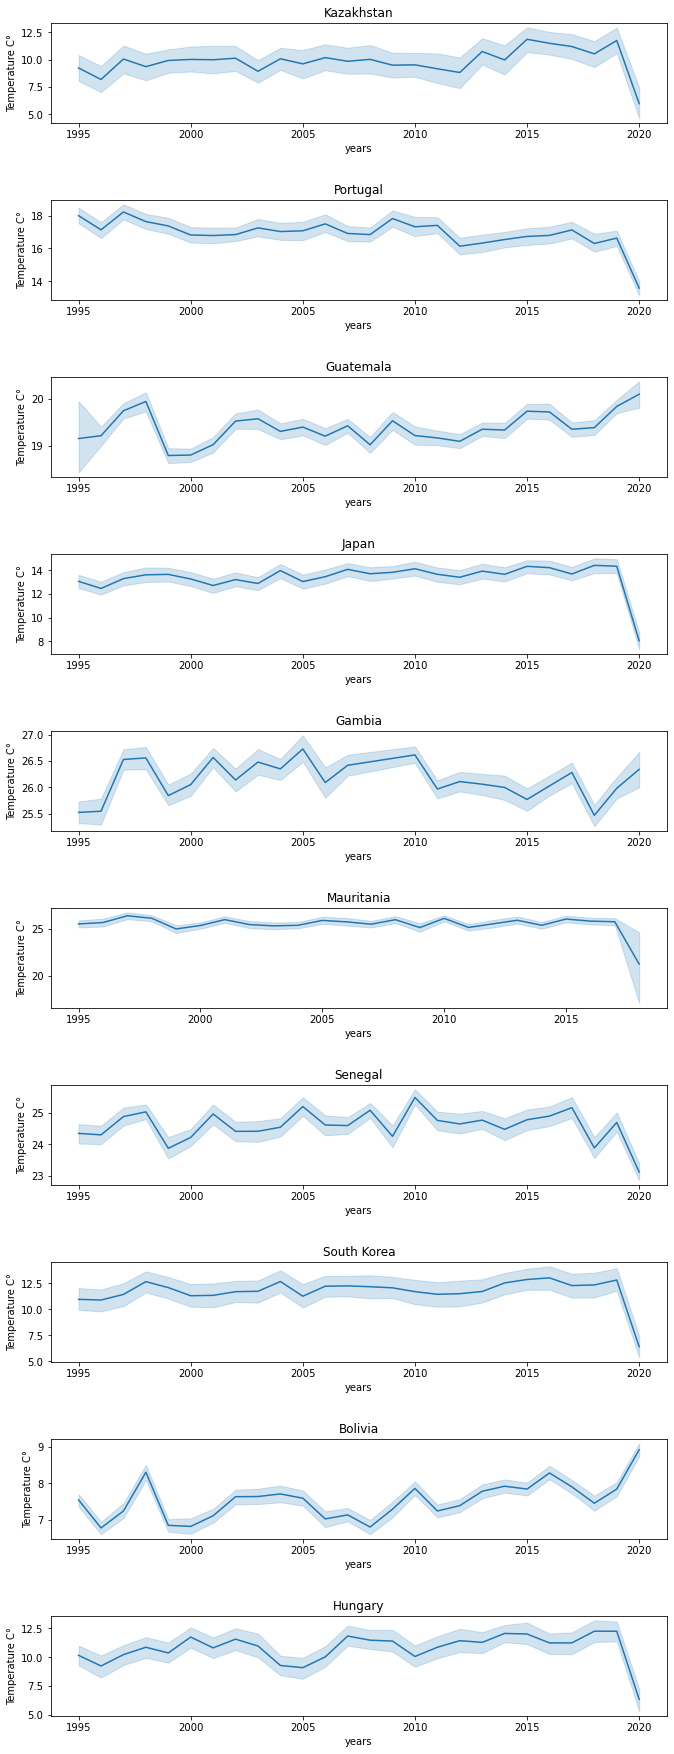

In [152]:
import warnings

warnings.filterwarnings("ignore")

# On plot les temperatures pour différents pays 
fig,axs=plt.subplots(10,1,figsize=(10,25))
countries_names=df["Country"].unique()
np.random.shuffle(countries_names)
countries_names=countries_names[:10]
for i,ax in enumerate(axs.flatten()) :
    x=df[df["Country"]==countries_names[i]]["Year"]
    y=(df[df["Country"]==countries_names[i]]["AvgTemperature"]-32.0)/1.8
    g=sns.lineplot(x=x,y=y,ax=ax)
    ax.set_xlabel("years")
    ax.set_ylabel("Temperature C°") 
    ax.set_title(countries_names[i])
fig.tight_layout(pad=3.0)

# Forecast with Prophet

In [166]:
def Forecast(country_name,future_months=100) :
    m=Prophet(n_changepoints=1)
    m.fit(countries[country_name])
    future = m.make_future_dataframe(periods=future_months, freq = 'M')
    forecast = m.predict(future)
    return m,forecast

Example of forecasting for different countries :

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


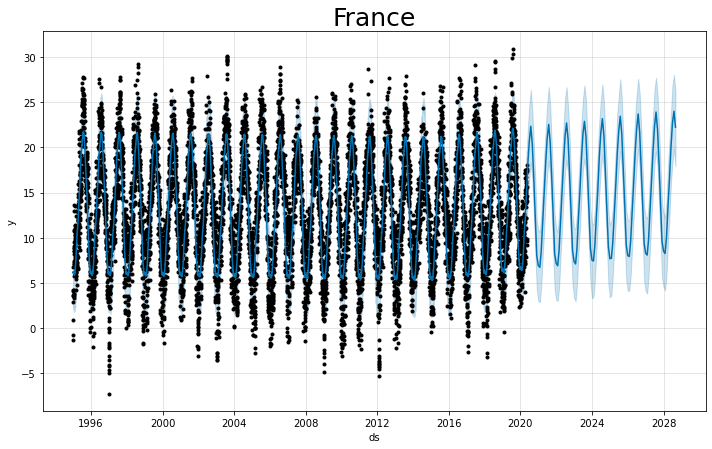

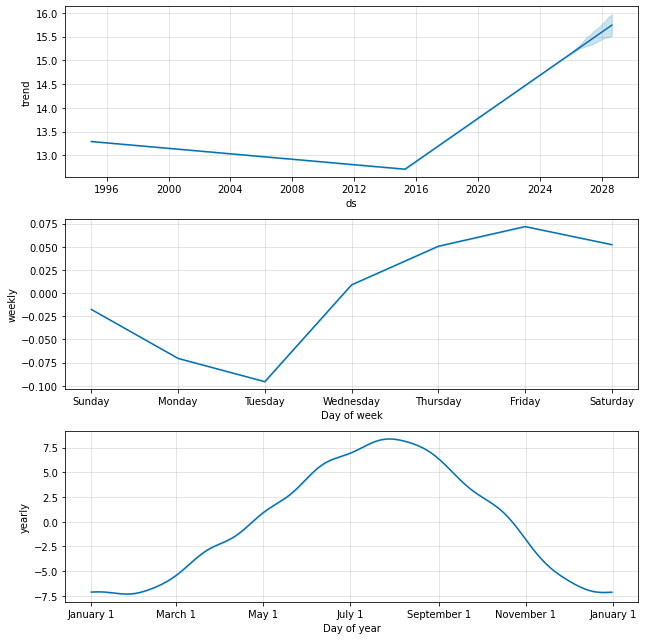

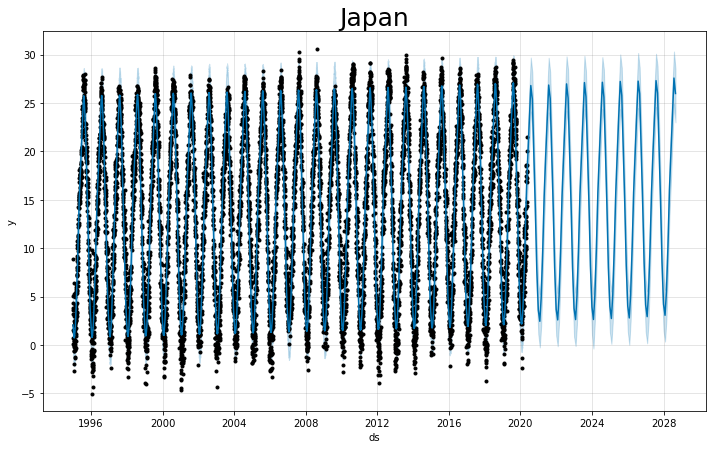

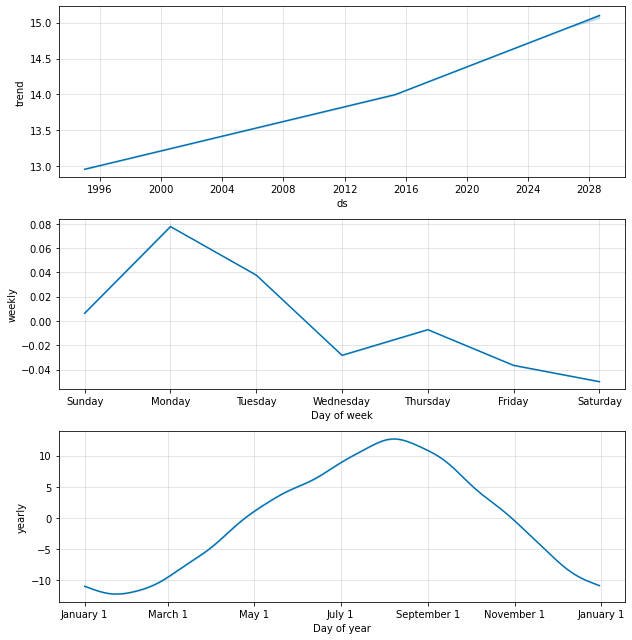

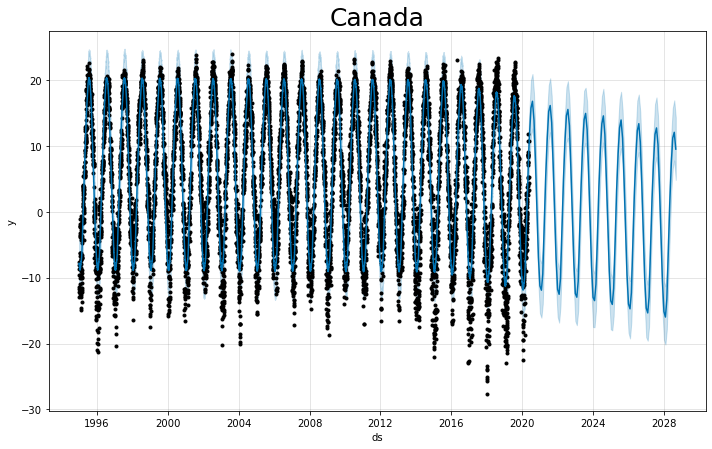

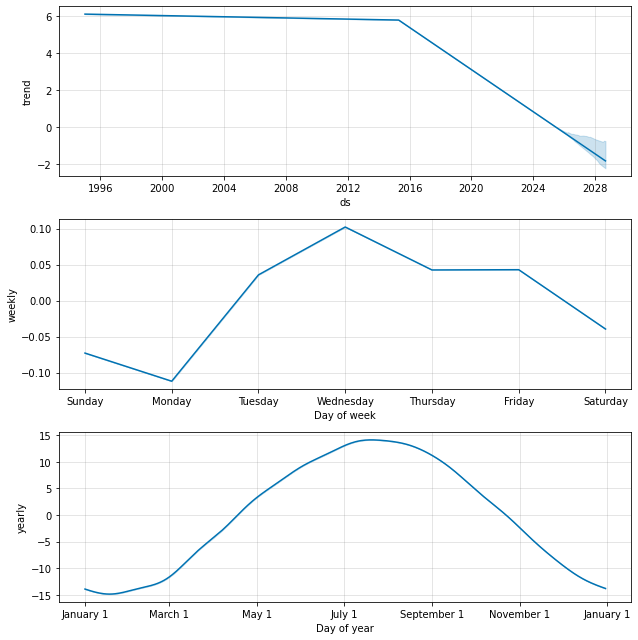

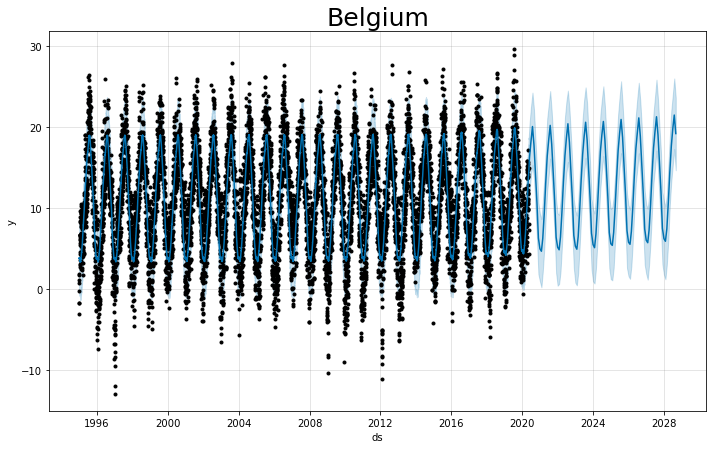

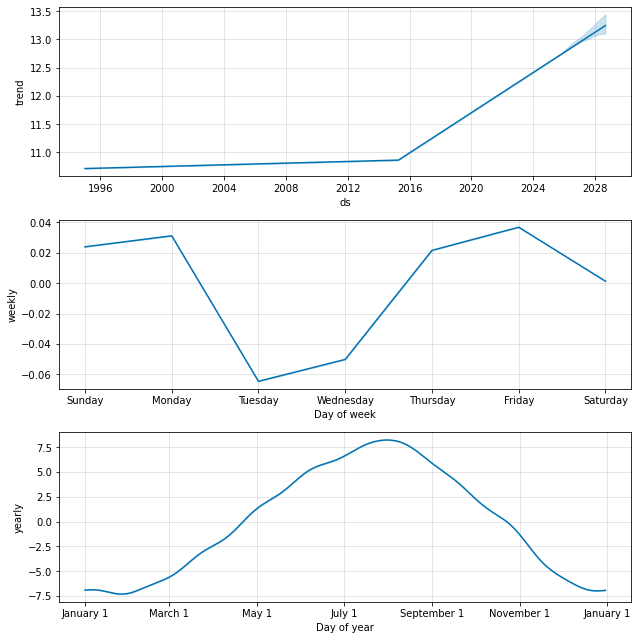

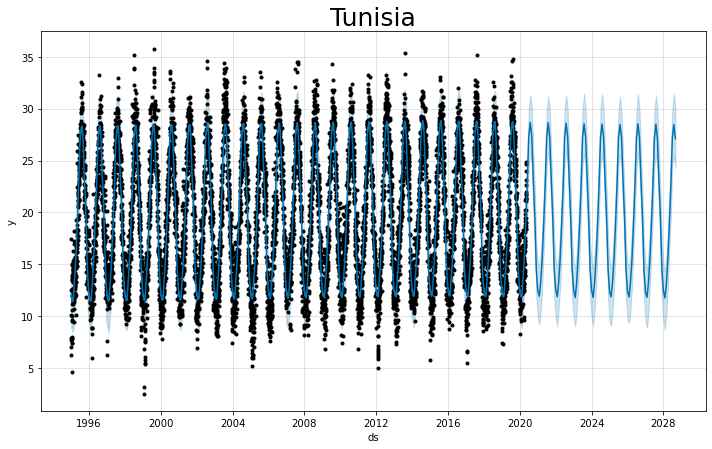

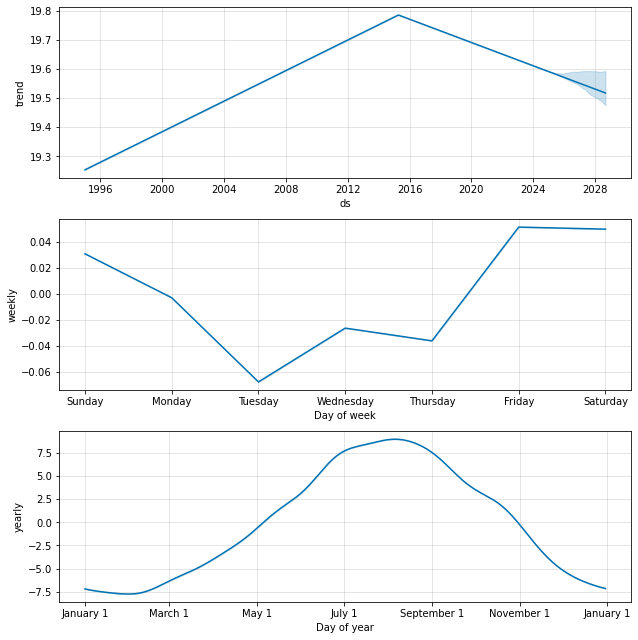

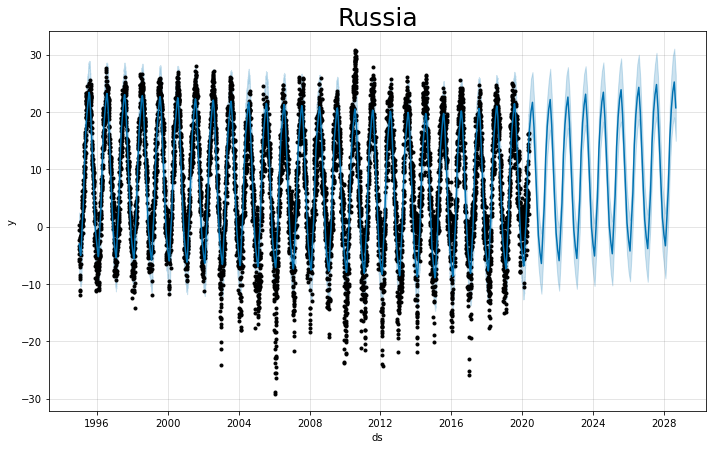

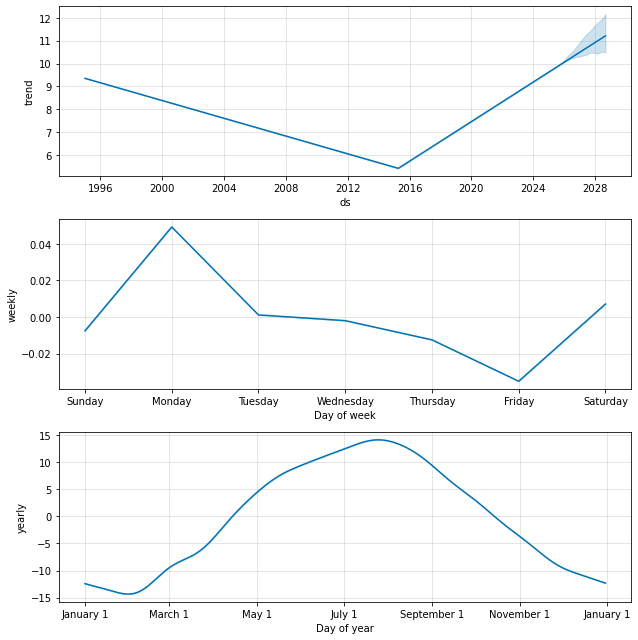

In [175]:
plot_countries=["France","Japan","Canada","Belgium","Tunisia","Russia"]
for count in plot_countries :
    m,forecast=Forecast(count)
    fig=m.plot(forecast)
    ax = fig.gca()
    ax.set_title(count, size=25)
    comps=m.plot_components(forecast)